```sql
WITH clean_mno as (select CASE 
    WHEN (Device_SIMServiceProviderBrandName = '3' AND  Device_SIMServiceProvider like '%Three Mobile%' ) THEN '3'
    WHEN (Device_SIMServiceProviderBrandName = 'O2' AND  Device_SIMServiceProvider = 'O2' ) THEN 'O2'
    WHEN (Device_SIMServiceProviderBrandName = 'Vodafone' AND  Device_SIMServiceProvider = 'Vodafone' ) THEN 'V'
    WHEN (Device_SIMServiceProviderBrandName = 'EE' AND  Device_SIMServiceProvider = 'EE' ) THEN 'EE'
    ELSE CONCAT('raw_',Device_SIMServiceProviderBrandName,'_',Device_SIMServiceProvider) 
END
 as cleaned_mno,CASE 

      WHEN Connection_Category = '4G' THEN '4' 
      WHEN Connection_Category = '5G NSA' THEN '5G NSA' 
      WHEN Connection_Category = '5G' THEN '5' 
      WHEN Connection_Category = '5G SA' THEN '5 SA'
      WHEN Connection_Category = 'FIVEG_UNKNOWN' THEN '5' 
      WHEN Connection_Category = '3G' THEN '3'
      WHEN Connection_Category = '2G' THEN '2' 
      WHEN Connection_Category = 'CALL_SERVICE_ONLY' THEN 'C' 
      WHEN Connection_Category = 'NO_SERVICE' THEN 'NO'
      ELSE Connection_Category 

    END AS Connection_Category_clean,

 CASE
    WHEN (QOS_UploadThroughputTestStatus = 'COMPLETED') THEN 0
    WHEN (QOS_UploadThroughputTestStatus = 'TIMEOUT_CONNECTING_TO_REMOTE') THEN 1
    WHEN (QOS_UploadThroughputTestStatus = 'SOCKET_OPEN_FAILURE') THEN 2
    WHEN (QOS_UploadThroughputTestStatus = 'TIMEOUT') THEN 3
    WHEN (QOS_UploadThroughputTestStatus = 'UPLOAD_RESPONSE_ERROR') THEN 4
    WHEN (QOS_UploadThroughputTestStatus = 'CONNECTION_CHANGE') THEN 5    
    WHEN (QOS_UploadThroughputTestStatus = 'SERVER_ERROR') THEN 6
    ELSE -1
 END as test_status,*
 
 FROM `onx-ofcom-uk.ONXData.UnitedKingdom_Mobile_Last365Day`) SELECT count(1) as c, cleaned_mno,test_status,2 * FLOOR(QOS_SignalStrength / 2) AS QOS_SignalStrength,Connection_Category_clean FROM clean_mno 
 WHERE QOS_UploadThroughputTestStatus IS NOT NULL AND QOS_SignalStrength IS NOT NULL 
 GROUP BY cleaned_mno,test_status,QOS_SignalStrength,Connection_Category_clean
```

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import scipy.stats
import numpy as np
from statsmodels.stats.proportion import proportion_confint
from scipy.optimize import curve_fit
import numpy as np
from sklearn.metrics import r2_score

In [2]:
if False:
    df = pd.read_csv('data/bquxjob_4fc765cf_1949f117271.csv')
# Sawtooth
else:
    #df = pd.read_csv('data/bquxjob_8118ddd_1949ea1f4a9.csv')
    #df = pd.read_csv('data/bquxjob_672527f8_1949f0450c8.csv')
    df = pd.read_csv('data/bquxjob_678310ab_194adb8e06b.csv') # Break out 5G NSA
# Snapped to 2db

In [3]:
df['cleaned_mno'].value_counts()[0:20]

cleaned_mno
O2                               1095
V                                1007
EE                                846
raw_Tesco Mobile_Tesco            819
raw_giffgaff_giffgaff             811
3                                 787
raw_Sky Mobile_Sky                762
raw_Lebara_Lebara                 665
raw_iD Mobile_iD Mobile           628
raw_SMARTY_Smarty                 592
raw_Lycamobile_EE                 495
raw_Talkmobile_TalkMobile         450
raw_O2_O2 - UK                    367
raw_Utility Warehouse Club_EE     332
raw_BT Mobile_BT                  330
raw_giffgaff_O2                   326
raw_Tesco Mobile_TESCO            272
raw_1p mobile_EE                  262
raw_SMARTY_Three Mobile           260
raw_3_3                           219
Name: count, dtype: int64

In [4]:
df.dtypes

c                              int64
cleaned_mno                   object
test_status                    int64
QOS_SignalStrength           float64
Connection_Category_clean     object
dtype: object

In [5]:
df['Connection_Category_clean'].isna().sum()
# Some have the connection category undefined

515

In [6]:
df.sample(5)

,c,cleaned_mno,test_status,QOS_SignalStrength,Connection_Category_clean
5140,1,O2,1,-82.0,2
4610,2,O2,4,-98.0,5 SA
11727,9727,raw_Tesco Mobile_Tesco,0,-112.0,4
3181,27,V,4,-98.0,5G NSA
11411,1,raw_Tesco Mobile_TESCO,-1,-84.0,3


## Test status 0/1

In [7]:
def clean_test_status(status):
    return status.apply(lambda x: '1' if x==0 else 0)

In [8]:
df['test_status'] = clean_test_status(df['test_status'])

## Drop all but big 4 MNOs

In [9]:
df_big_four = df[df['cleaned_mno'].apply(lambda x:x in ['O2','3','V','EE'])]

In [10]:
df_big_four.sample(5)

,c,cleaned_mno,test_status,QOS_SignalStrength,Connection_Category_clean
4223,12,EE,0,-88.0,4
3547,2,EE,1,-72.0,3
1843,7,3,1,-134.0,4
3796,5,EE,1,-64.0,3
3895,1,EE,0,-72.0,4


In [11]:
if False:
    df = df_big_four

In [12]:
def get_baseline_success(df):
    print(df.groupby('test_status')['c'].sum())
    vals = df.groupby('test_status')['c'].sum().values
    rate = 100 * vals[1] / float(vals[0] + vals[1])
    print('Baseline success = {:.1f}%'.format(rate))
    return rate
# This is the baseline succes rate 

In [13]:
get_baseline_success(df)

test_status
0    1420898
1    4446516
Name: c, dtype: int64
Baseline success = 75.8%


75.78323261320917

In [14]:
get_baseline_success(df_big_four)

test_status
0     980666
1    3175530
Name: c, dtype: int64
Baseline success = 76.4%


76.40472201022281

In [15]:
df.sample(5)

,c,cleaned_mno,test_status,QOS_SignalStrength,Connection_Category_clean
13511,1,raw_Vodafone_vodafone UK,0,-50.0,2
1383,37,NaN,0,-96.0,3
5177,6,O2,0,-110.0,5 SA
9663,1,raw_Phone Co-op_EE,0,-74.0,4
14018,1,raw_Talkmobile_TalkMobile,0,-112.0,5G NSA


In [16]:
df[df['QOS_SignalStrength'] == -16]['c'].sum()

18

## Drop category and MNO and aggregate

In [17]:
df.head()

,c,cleaned_mno,test_status,QOS_SignalStrength,Connection_Category_clean
0,3,raw_Tesco Mobile_O2,1,-80.0,4
1,1,raw_iD Mobile_iD,0,-94.0,4
2,2,raw_One NZ_Vodafone,1,-84.0,4
3,2,raw_3_Smarty,1,-110.0,4
4,2,raw_Lebara_Vodafone,0,-90.0,4


In [18]:
g = df.groupby(['QOS_SignalStrength','test_status'])
# Drops technology and MNO

In [19]:
if False:
    g = df.groupby(['QOS_SignalStrength','test_status','Connection_Category_clean'])
# Drops MNO only

## Sum over groups

In [20]:
aggregated = g.apply(lambda x: x['c'].sum())

In [25]:
aggregated[aggregated.index.get_level_values(0) == -16]

QOS_SignalStrength  test_status
-16.0               0               5
                    1              13
dtype: int64

In [22]:
aggregated.sample(10)

QOS_SignalStrength  test_status
-18.0               1                  15
-116.0              1              100127
-16.0               1                  13
-136.0              0                 196
-4.0                1                  10
-6.0                1                   8
-118.0              1               51520
-106.0              0               96311
-92.0               1              201608
-36.0               1                  20
dtype: int64

In [23]:
n = aggregated.groupby(level=[0]).sum()

In [24]:
n.sample(5)

QOS_SignalStrength
-130.0      2036
-72.0      45606
-12.0         11
-138.0       162
-100.0    352687
dtype: int64

## Normalise

In [26]:
normalised = aggregated/ n

In [27]:
normalised.sample(5)

QOS_SignalStrength  test_status
-116.0              1              0.498407
-86.0               1              0.860204
-70.0               0              0.140015
-60.0               1              0.826726
-78.0               1              0.863770
dtype: float64

In [28]:
len(pd.unique(normalised.index.get_level_values(0)))

70

In [29]:
normalised = normalised[normalised.index.get_level_values(1) == '1']
# Drop failure rate

In [30]:
len(pd.unique(normalised.index.get_level_values(0)))

70

In [31]:
normalised.sample(5)

QOS_SignalStrength  test_status
-34.0               1              0.771429
-40.0               1              0.675676
-12.0               1              0.727273
-32.0               1              0.650000
-82.0               1              0.862440
dtype: float64

In [32]:
normalised = normalised.droplevel(1)

In [33]:
normalised.sample(5)

QOS_SignalStrength
-102.0    0.810630
-56.0     0.785151
-120.0    0.338241
-90.0     0.856041
-20.0     0.666667
dtype: float64

In [34]:
nDict = n.to_dict()

In [35]:
###normalised['n'] = map(lambda x:nDict[x],normalised.index.values)

In [36]:
normalised = pd.DataFrame(index = normalised.index, data = {'rate' : normalised.values\
                          ,'n':map(lambda x:nDict[x],normalised.index.values)})
# Turn MultiIndex series into dataframe

In [37]:
normalised.sample(5)

,rate,n
QOS_SignalStrength,,
-24.0,0.777778,18
-112.0,0.636091,341341
-66.0,0.849970,20016
-136.0,0.240310,258
-84.0,0.860878,135665


## Add CIs

In [38]:
proportion_confint(1,100, method = 'binom_test',alpha = 0.95)

(0.009900989118484497, 0.019801982164531506)

In [39]:
def get_ci(row, alpha = 0.1):
    return proportion_confint(int(row['rate'] * row['n']), row['n'], method = 'binom_test',alpha = alpha)

In [40]:
normalised['intervals'] = normalised.apply(get_ci,axis = 1)

In [41]:
normalised.sample(5)

,rate,n,intervals
QOS_SignalStrength,,,
-20.0,0.666667,15,"(0.4330098650285411, 0.8322242170693508)"
-136.0,0.240310,258,"(0.19769311679355694, 0.2868983264081499)"
-114.0,0.565886,280380,"(0.5643447953252569, 0.567426326877214)"
-52.0,0.414584,5801,"(0.403983685341317, 0.4252727467648499)"
-100.0,0.824754,352687,"(0.8236976940255651, 0.8258043762331357)"


In [42]:
def get_db_at_rate(df,rate = 0.5):
    return df[(df['rate'] > rate) & (df.index > -130)].sort_index().index[0]
# Add a hack to exclude very low signal with high rate but low n

## Fit a logistic

In [43]:
def logifunc(x,A,x0,k,off):
    # Max val = off + A
    # Mid point = x0
    # Steepness = k
    return A / (1 + np.exp(-k*(x-x0)))+off

In [44]:
def fit_logistic(normalised, lower = -140, upper = -70):

    if type(normalised.index) == pd.core.indexes.multi.MultiIndex:
        normalised_subset = normalised.loc[(normlised.index.get_level_values(0) > lower) & (normlised.index.get_level_values(0) < upper)]
        # Need to filter differently on Multiindex if it's a group
    else:    
        normalised_subset = normalised[(normalised.index > lower) & (normalised.index < upper)]
        # Hard code dropping extremes

    p0 = [0.6,-120,0.05,0.2]
    # Estimate initial parameters

    try:
        popt, pcov = curve_fit(logifunc, normalised_subset.index, normalised_subset['rate'],p0 = p0)
        fitted = True
    except:
        print('*** Fit not converging')
        fitted = False
        fit_string = ''

    if fitted:
        r2 = r2_score(normalised_subset['rate'], logifunc(normalised_subset.index, *popt))
    
        fit_string = 'r^2 = {:.3f}'.format(r2)
        #fit_string = fit_string +'\n' + ','.join(['{:.2f}'.format(p) for p in popt])
        fit_string = fit_string +'\n' + 'Slope = {:.2f}'.format(popt[2])
        fit_string = fit_string +'\n' + 'Lower = {:.2f}'.format(popt[3])
        fit_string = fit_string +'\n' + 'Upper = {:.2f}'.format(popt[0] + popt[3])

    if fitted:
        return popt,pcov,normalised_subset,r2,fit_string,fitted
    else:
        return None,None,normalised_subset,None,fit_string,fitted

## Plot (Full Dataset)

In [45]:
normalised['intervals'].sample(5)

QOS_SignalStrength
-20.0     (0.4330098650285411, 0.8322242170693508)
-24.0        (0.5811906138372, 0.8993590048806026)
-78.0     (0.8618197606186797, 0.8656952216486633)
-70.0     (0.8569456965677358, 0.8629669276043106)
-30.0    (0.32491857225797033, 0.6750814271297565)
Name: intervals, dtype: object

In [46]:
def plot_rate(df, name = 'trash',add_rate = False, add_fit = True):
    ax = plt.subplot()
    
    x_lims = [-140,-40]
    
    main_colour = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
    
    df.plot(kind = 'line', ax = ax, y = 'rate', legend = False)
    # Plot rate

    popt,pcov,normalised_subset,r2,fit_string, fitted = fit_logistic(df)
    
    if fitted:
        _ = plt.plot(normalised_subset.index,logifunc(normalised_subset.index, *popt), linestyle = '--')
    
        plt.annotate(fit_string, xy = (0.6,0.1),xycoords = 'axes fraction')
        # Add fit
    
    plt.title('{:s} (n = {:.1f} k)'.format(name,df['n'].sum()/1000.))
    # Label with total sample size
    
    ax.fill_between(df.index, df['intervals'].apply(lambda x:x[0]), df['intervals'].apply(lambda x:x[1]), alpha = 0.5)
    # Add CIs

    if add_rate:
        for rate in [0.5, 0.75, 0.85]:
            plt.plot([get_db_at_rate(df,rate), get_db_at_rate(df,rate)],[0,rate], color = 'grey', linestyle = '--')
            plt.plot([x_lims[0],get_db_at_rate(df,rate)], [rate,rate], color = 'grey', linestyle = '--')
        
            plt.annotate('{:d}% : {:.1f} dB'.format(int(rate * 100), get_db_at_rate(df,rate)),xy = (-139, rate + 0.015),xycoords = 'data', color = 'grey')
        # Add annotations and lines at certain rates
    
    plt.xlim(x_lims)
    plt.ylim([0.0,1.0])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # Drop frame
    
    plt.ylabel('Connectivity Success Rate')
    plt.xlabel('Signal Strength (dB)')
    # Label
    
    plt.savefig('figs/{:s}.png'.format(name),dpi = 300)
    plt.savefig('figs/{:s}.svg'.format(name))
    # Save

    plt.show()

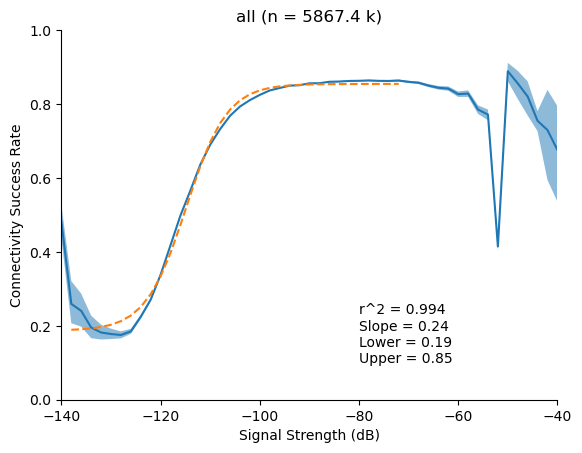

In [47]:
plot_rate(normalised,name = 'all')

## Plot by MNO

In [48]:
def clean_non_big_four(mno):

    if mno in ['O2','3','V','EE']:
        return mno
    else:
        return 'other'

In [49]:
df['cleaned_mno'] = df['cleaned_mno'].apply(clean_non_big_four)

In [50]:
g = df.groupby(['QOS_SignalStrength','test_status','cleaned_mno'])

In [51]:
aggregated = g.apply(lambda x: x['c'].sum())

In [52]:
n = aggregated.groupby(level=[0,2]).sum()
# Sum over groups of (signal,mno)

nDict = n.to_dict()

In [53]:
normalised = aggregated / n

In [54]:
normalised.sample(5)

QOS_SignalStrength  cleaned_mno  test_status
-104.0              V            1              0.813893
-74.0               V            1              0.883258
                    O2           1              0.845065
-52.0               other        0              0.509597
-78.0               EE           1              0.888387
dtype: float64

In [55]:
normalised = normalised[normalised.index.get_level_values(2) == '1']
normalised = normalised.droplevel(2)
# Drop failure rate

In [56]:
def process_group(group,name = 'mno', add_rate = False):

    name = '{:s}_{:s}'.format(name, group.index[0][1].lower())
    
    group = pd.DataFrame(index = group.index, data = {'rate' : group.values\
                          ,'n':map(lambda x:nDict[x],group.index.values)})
    group = group.droplevel(1)
    # Now we can drop the MNO index
    
    group['intervals'] = group.apply(get_ci,axis = 1)
    plot_rate(group, name = name, add_rate = add_rate)
    #return group

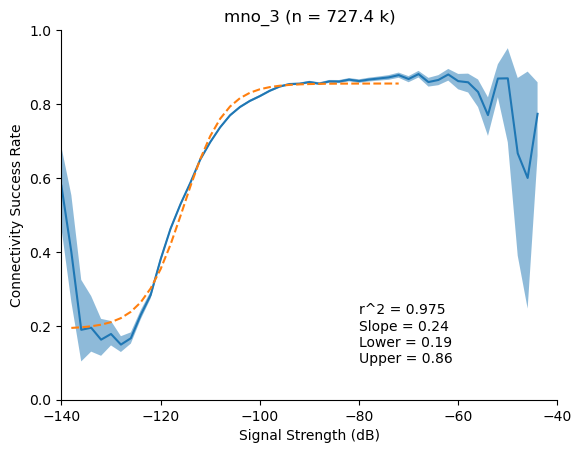

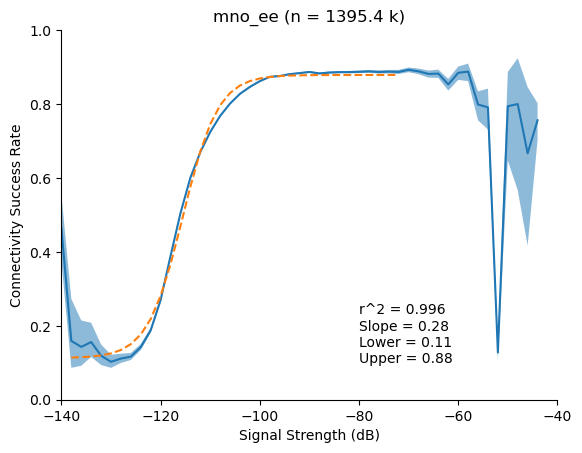

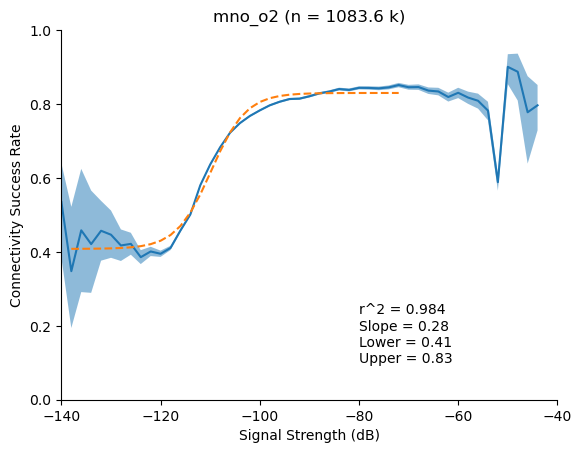

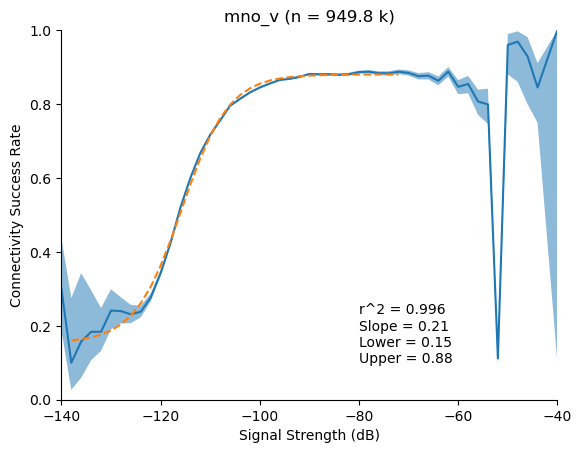

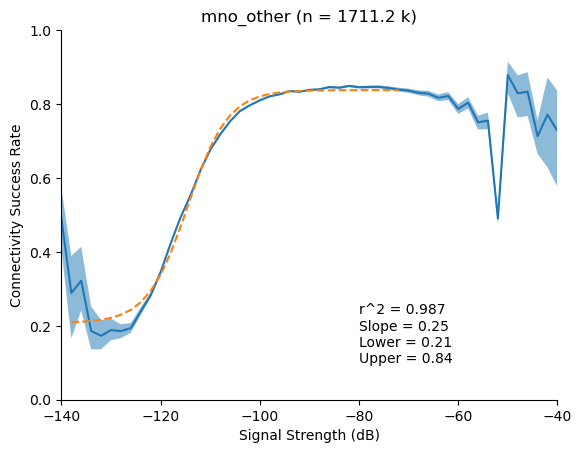

cleaned_mno
3        None
EE       None
O2       None
V        None
other    None
dtype: object

In [57]:
normalised.groupby('cleaned_mno').apply(lambda x: process_group(x,name = 'mno'))

## Plot by Technology

In [818]:
df.head()

,c,cleaned_mno,test_status,QOS_SignalStrength,Connection_Category_clean
0,1,raw_Sky Mobile_O2,1,-82.0,5G NSA
1,1,raw_Vodafone_50+,1,-106.0,4
2,1,raw_Vodafone_TalkMobile,1,-94.0,4
3,1,raw_Tesco Mobile_O2,0,-118.0,4
4,1,raw_Talk Talk_EE,1,-118.0,4


*** Fit not converging


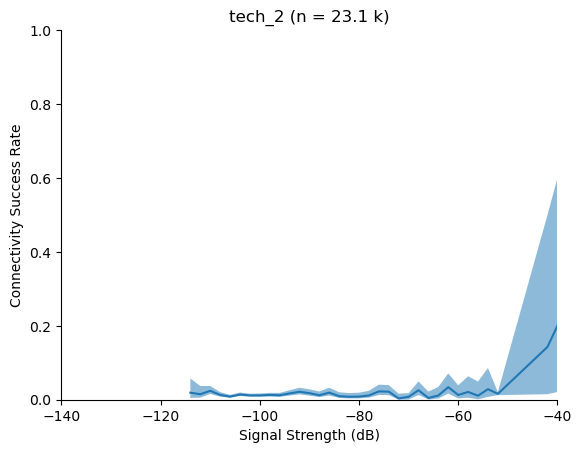

C:\Users\Alex.Rutherford\AppData\local\conda3\Lib\site-packages\pandas\core\indexes\base.py:945: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*new_inputs, **kwargs)


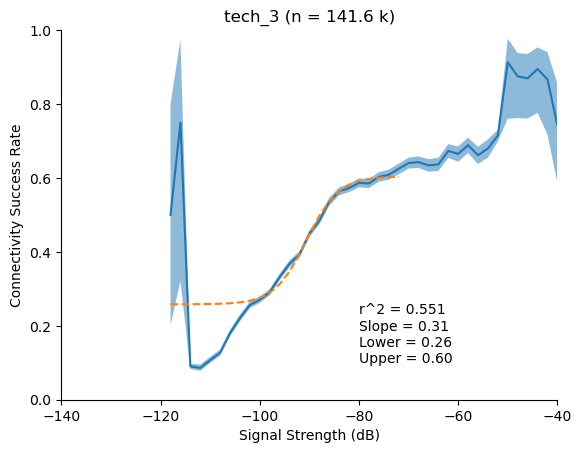

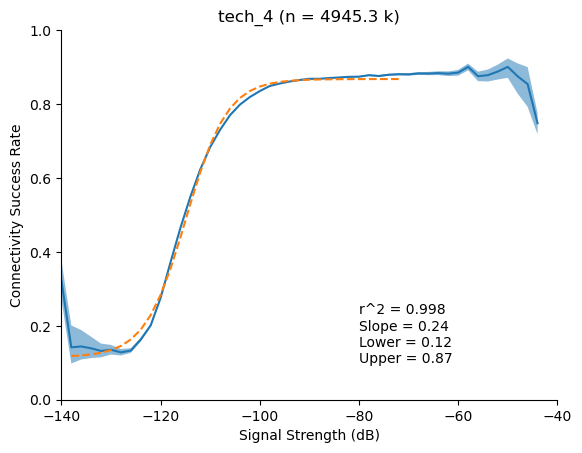

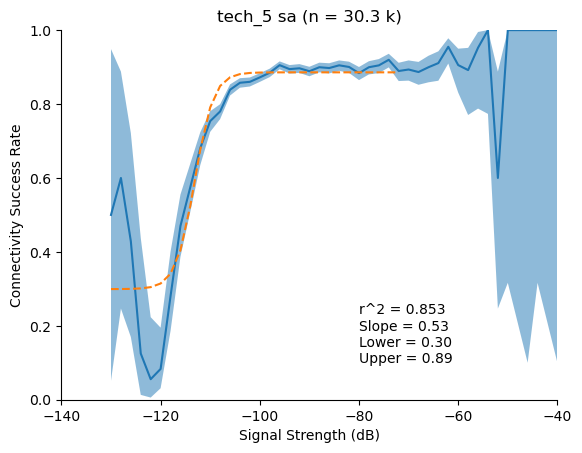

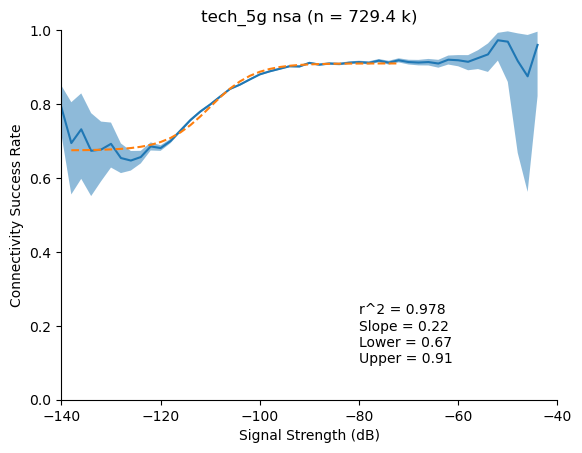

*** Fit not converging


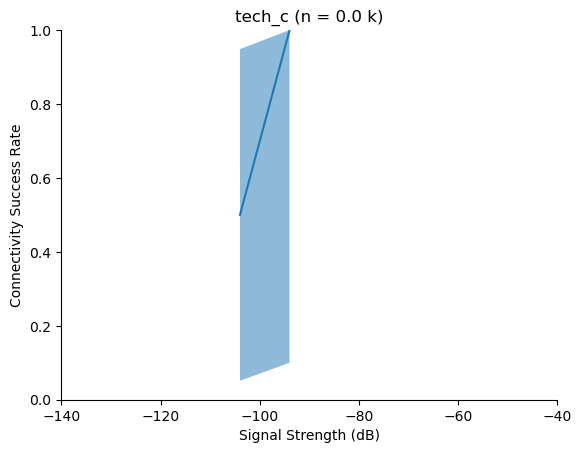

Connection_Category_clean
2         None
3         None
4         None
5 SA      None
5G NSA    None
C         None
dtype: object

In [1098]:
g = df.groupby(['QOS_SignalStrength','test_status','Connection_Category_clean'])
aggregated = g.apply(lambda x: x['c'].sum())
n = aggregated.groupby(level=[0,2]).sum()
# Sum over groups of (signal,tech)
nDict = n.to_dict()
normalised = aggregated / n
normalised = normalised[normalised.index.get_level_values(2) == '1']
normalised = normalised.droplevel(2)
# Drop failure rate
normalised.groupby('Connection_Category_clean').apply(lambda x: process_group(x,name = 'tech',add_rate=False))